# Data preprocessing
Merge the eight raw UWB captures (8000 rows total) and build two features for modeling:
- fp_fb_gap: index gap between detected first path and first bounce
- energy_ratio: normalized ROI energy divided by total normalized CIR energy
Steps are kept small and reproducible.

In [21]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import find_peaks

# constants
ROI_START, ROI_END = 740, 800
TS_DW1000 = 1 / (128 * 499.2e6)
TS_ACCUMULATOR = TS_DW1000 * 64
FP_INDEX_SCALE = 64.0
EPS = 1e-6

# Resolve dataset directory robustly
DATA_DIR = None
candidate = None

# 1) honor environment variables if set
for env in ("DATA_DIR", "DATASET_DIR", "DATASET"):
    val = os.getenv(env)
    if val:
        p = Path(val).expanduser().resolve()
        if p.exists():
            DATA_DIR = p
            break

# 2) candidate roots to check
candidate_roots = [
    Path.cwd(),
    Path.cwd() / 'capstone',
]
if '__file__' in globals():
    pfile = Path(__file__).resolve()
    candidate_roots += [pfile.parent, pfile.parent.parent]

# include any 'candidate' global if present (from prior cells)
candidate_global = globals().get('candidate')
if isinstance(candidate_global, Path):
    candidate_roots.append(candidate_global.parent)

# check for dataset folder in candidate roots
for root in candidate_roots:
    try:
        cand = (root / 'dataset').resolve()
    except Exception:
        continue
    if cand.exists():
        DATA_DIR = cand
        break

# 3) fallback: search upwards from cwd for 'dataset'
if DATA_DIR is None:
    cur = Path.cwd().resolve()
    for _ in range(6):
        cand = (cur / 'dataset').resolve()
        if cand.exists():
            DATA_DIR = cand
            break
        if cur.parent == cur:
            break
        cur = cur.parent

if DATA_DIR is None:
    checked = ', '.join(str((r / 'dataset').resolve()) for r in candidate_roots if r is not None)
    raise FileNotFoundError(f'Could not locate dataset folder. Checked: {checked}')

BASE_DIR = DATA_DIR.parent
print('Using dataset directory:', DATA_DIR)

Using dataset directory: C:\Users\preca\OneDrive - Singapore Institute Of Technology\Desktop\uwb_localization\capstone\dataset


## 1. Load and merge raw CSV files
Each CSV has 1000 samples. Attach labels and metadata, then concatenate to a single frame.

In [22]:
files = [
    ('LOS_2m_living_room_home.csv', 'LOS', 2.0, 'LOS 2 m living room'),
    ('LOS_4.3m_living_room_corner_home.csv', 'LOS', 4.3, 'LOS 4.3 m corner'),
    ('LOS_4.63m_meetingroom_corner-glass_MR201SIT.csv', 'LOS', 4.63, 'LOS 4.63 m meeting room'),
    ('LOS_8.34m_basement_corner-concrete_E2B1SIT.csv', 'LOS', 8.34, 'LOS 8.34 m basement'),
    ('NLOS_1.56m_open_door_home.csv', 'NLOS', 1.56, 'NLOS 1.56 m open door'),
    ('NLOS_2.24m_meetingroom_table_laptop_MR201SIT.csv', 'NLOS', 2.24, 'NLOS 2.24 m meeting room'),
    ('NLOS_4.4m_close_door_home.csv', 'NLOS', 4.4, 'NLOS 4.4 m closed door'),
    ('NLOS_7.67m_basement_concrete_thickconcretewall_E2B1SIT.csv', 'NLOS', 7.67, 'NLOS 7.67 m basement'),
]

frames = []
print('=' * 72)
print('Loading raw CSV files')
print('=' * 72)

# DATA_DIR is resolved in the first cell; fail fast if missing
if DATA_DIR is None:
    raise RuntimeError('DATA_DIR not set; please run the first cell to resolve dataset path.')

for fname, label, d_true, scenario in files:
    df = pd.read_csv(DATA_DIR / fname)
    df['Label'] = 'LOS' if label.startswith('LOS') else 'NLOS'
    df['d_true'] = d_true
    df['scenario'] = scenario
    frames.append(df)
    print(f"{scenario:35s} | rows={df.shape[0]:5d} | label={df['Label'].iloc[0]} | d_true={d_true:4.2f} m")

data = pd.concat(frames, ignore_index=True)
print('Merged shape:', data.shape)
assert data.shape[0] == 8000, 'Expected 8000 rows after merging all eight files.'
data.head()

Loading raw CSV files
LOS 2 m living room                 | rows= 1000 | label=LOS | d_true=2.00 m
LOS 4.3 m corner                    | rows= 1000 | label=LOS | d_true=4.30 m
LOS 4.63 m meeting room             | rows= 1000 | label=LOS | d_true=4.63 m
LOS 8.34 m basement                 | rows= 1000 | label=LOS | d_true=8.34 m
NLOS 1.56 m open door               | rows= 1000 | label=NLOS | d_true=1.56 m
NLOS 2.24 m meeting room            | rows= 1000 | label=NLOS | d_true=2.24 m
NLOS 4.4 m closed door              | rows= 1000 | label=NLOS | d_true=4.40 m
NLOS 7.67 m basement                | rows= 1000 | label=NLOS | d_true=7.67 m
Merged shape: (8000, 1028)


,Capture_ID,Distance,FP_INDEX,FP_AMPL1,FP_AMPL2,FP_AMPL3,RXPACC,STD_NOISE,MAX_NOISE,CIR0,...,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015,Label,d_true,scenario
0,0,1.951188,47887,6794,7577,7081,118,64,1635,271,...,47,128,66,47,17,140,35,LOS,2.0,LOS 2 m living room
1,1,1.876143,48066,6564,7433,7098,118,60,1476,230,...,239,90,132,35,125,42,49,LOS,2.0,LOS 2 m living room
2,2,1.894904,47840,7071,7552,6047,118,48,1191,281,...,72,75,96,70,147,50,66,LOS,2.0,LOS 2 m living room
3,3,1.932427,47634,7102,7397,6927,118,56,1371,105,...,184,130,79,94,43,82,93,LOS,2.0,LOS 2 m living room
4,4,1.969950,47690,6727,7539,7420,118,56,1392,260,...,24,248,25,96,166,85,103,LOS,2.0,LOS 2 m living room


## 2. Locate CIR columns
Grab the 1016 CIR samples (CIR0..CIR1015) for feature engineering.

In [23]:
cir_cols = [c for c in data.columns if c.startswith('CIR') and c[3:].isdigit()]
cir_cols.sort(key=lambda x: int(x[3:]))
print(f"Found {len(cir_cols)} CIR samples per row.")
print(f"Index range: {cir_cols[0]} .. {cir_cols[-1]}")

Found 1016 CIR samples per row.
Index range: CIR0 .. CIR1015


## 3. Helper functions (MAD based)
Utility functions for noise-robust peak picking and bounce detection.

In [24]:
def calculate_mad(signal):
    'Median Absolute Deviation scaled to estimate noise sigma.'
    median = np.median(signal)
    mad = np.median(np.abs(signal - median))
    return 1.4826 * mad


def detect_first_path_peak(cir_waveform, roi_start=ROI_START, roi_end=ROI_END):
    roi = cir_waveform[roi_start:roi_end + 1]
    sigma_noise = calculate_mad(roi[:20])
    threshold = sigma_noise + 0.3 * (roi.max() - sigma_noise)
    peaks, _ = find_peaks(roi, height=threshold, distance=3)
    if len(peaks) == 0:
        local_max = np.argmax(roi)
        return roi_start + local_max, roi[local_max]
    first_peak_local = peaks[0]
    return roi_start + first_peak_local, roi[first_peak_local]


def detect_first_bounce(cir_waveform, fp_idx, roi_start=ROI_START, roi_end=ROI_END):
    search_start = int(fp_idx) + 5
    if search_start >= roi_end:
        return np.nan
    roi = cir_waveform[search_start:roi_end + 1]
    full_roi = cir_waveform[roi_start:roi_end + 1]
    sigma_noise = calculate_mad(full_roi)
    threshold = sigma_noise + 0.25 * (full_roi.max() - sigma_noise)
    peaks, _ = find_peaks(roi, height=threshold, distance=5)
    if len(peaks) == 0:
        return np.nan
    return search_start + peaks[0]

print('Helper functions ready: calculate_mad, detect_first_path_peak, detect_first_bounce')

Helper functions ready: calculate_mad, detect_first_path_peak, detect_first_bounce


## 4. First path and first bounce features
Detect peaks, then derive fp_fb_gap (index gap) and first_bounce_delay_ns.

In [25]:
# Convert CIR columns to a numpy array for faster looping
cir_matrix = data[cir_cols].to_numpy(dtype=float)

fp_idx_list = []
fp_amp_list = []
for i, wave in enumerate(cir_matrix):
    idx, amp = detect_first_path_peak(wave)
    fp_idx_list.append(float(idx) if not np.isnan(idx) else np.nan)
    fp_amp_list.append(float(amp) if not np.isnan(amp) else np.nan)
    if (i + 1) % 1000 == 0:
        print(f'First path processed: {i + 1} / {len(cir_matrix)}')

data['fp_peak_idx'] = fp_idx_list
data['fp_peak_amp'] = fp_amp_list

fb_idx_list = []
fp_idxs = data['fp_peak_idx'].to_numpy(dtype=float)
for i, (wave, fp_idx) in enumerate(zip(cir_matrix, fp_idxs)):
    if np.isnan(fp_idx):
        fb_idx = np.nan
    else:
        # guard against out-of-range and cast to int for indexing
        try:
            fb_idx = detect_first_bounce(wave, int(fp_idx))
        except Exception:
            fb_idx = np.nan
    fb_idx_list.append(fb_idx)
    if (i + 1) % 1000 == 0:
        print(f'First bounce processed: {i + 1} / {len(cir_matrix)}')

data['first_bounce_idx'] = fb_idx_list
data['fp_fb_gap'] = data['first_bounce_idx'] - data['fp_peak_idx']
data['fp_to_fb_gap'] = data['fp_fb_gap']  # keep compatible naming

data['first_bounce_delay_ns'] = data['fp_fb_gap'] * TS_ACCUMULATOR * 1e9

valid_fb = data['first_bounce_idx'].notna().sum()
print(f'First bounce detected for {valid_fb} rows out of {len(data)}')
print(data[['fp_peak_idx', 'first_bounce_idx', 'fp_fb_gap', 'first_bounce_delay_ns']].describe())

First path processed: 1000 / 8000
First path processed: 2000 / 8000
First path processed: 3000 / 8000
First path processed: 4000 / 8000
First path processed: 5000 / 8000
First path processed: 6000 / 8000
First path processed: 7000 / 8000
First path processed: 8000 / 8000
First bounce processed: 1000 / 8000
First bounce processed: 2000 / 8000
First bounce processed: 3000 / 8000
First bounce processed: 4000 / 8000
First bounce processed: 5000 / 8000
First bounce processed: 6000 / 8000
First bounce processed: 7000 / 8000
First bounce processed: 8000 / 8000
First bounce detected for 6289 rows out of 8000
       fp_peak_idx  first_bounce_idx    fp_fb_gap  first_bounce_delay_ns
count  8000.000000       6289.000000  6289.000000            6289.000000
mean    749.866625        759.539036     9.846398               9.862178
std       2.476056          5.254507     4.715568               4.723125
min     743.000000        749.000000     6.000000               6.009615
25%     748.000000        7

## 5. Energy ratio feature (ROI vs full CIR)
Normalize CIR by RXPACC, then compare ROI energy to total energy.

In [26]:
rxpacc = data['RXPACC'].to_numpy(dtype=float)
cir_norm = cir_matrix / (rxpacc[:, None] + EPS)

roi_slice = slice(ROI_START, ROI_END + 1)
roi_energy = np.sum(cir_norm[:, roi_slice] ** 2, axis=1)
total_energy = np.sum(cir_norm ** 2, axis=1)
energy_ratio = np.where(total_energy > 0, roi_energy / total_energy, np.nan)

data['roi_energy'] = roi_energy
data['total_energy'] = total_energy
data['energy_ratio'] = energy_ratio

print(data[['roi_energy', 'total_energy', 'energy_ratio']].describe())

         roi_energy  total_energy  energy_ratio
count   8000.000000   8000.000000   8000.000000
mean   18584.560671  20042.820144      0.924800
std     3145.167507   3001.928163      0.051918
min     1203.180631   9350.998980      0.067494
25%    17155.057415  17886.147589      0.881141
50%    19466.239939  21070.242030      0.948824
75%    20971.326724  22033.958762      0.962895
max    22960.530205  24949.617862      0.983393


## 6. Save preprocessed dataset
Persist the merged data with new features for downstream notebooks (CSV).

In [27]:
output_path = DATA_DIR / 'uwb_preprocessed.csv'
data.to_csv(output_path, index=False)
print('Saved preprocessed dataset to:', output_path.resolve())

# Quick sanity preview of new columns
data[['fp_fb_gap', 'energy_ratio', 'roi_energy']].head()

Saved preprocessed dataset to: C:\Users\preca\OneDrive - Singapore Institute Of Technology\Desktop\uwb_localization\capstone\dataset\uwb_preprocessed.csv


,fp_fb_gap,energy_ratio,roi_energy
0,13.0,0.937617,20491.966975
1,NaN,0.927267,18698.091754
2,NaN,0.940726,18246.298240
3,7.0,0.943000,19728.222159
4,7.0,0.933798,19658.077590


### 6a. Validate missing values after save
Quick NaN overview to ensure the preprocessed dataset is clean.

In [28]:
na_counts = data.isna().sum()
missing_total = int(na_counts.sum())
print('Total missing values:', missing_total)

if missing_total > 0:
    top_missing = na_counts[na_counts > 0].sort_values(ascending=False).head(20)
    print('Columns with NaNs (top 20):')
    print(top_missing)
else:
    print('No NaNs detected across all columns.')


Total missing values: 6844
Columns with NaNs (top 20):
first_bounce_idx         1711
fp_fb_gap                1711
fp_to_fb_gap             1711
first_bounce_delay_ns    1711
dtype: int64


## 7. Correlation and baseline classification
Check how the engineered features separate LOS vs NLOS using correlation and a quick classifier (ROC/AUC and feature importance).

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use only the two context features for LNN
feat_cols = ['fp_fb_gap', 'energy_ratio']

corr_df = data.dropna(subset=feat_cols + ['Label']).copy()
corr_df['Label_num'] = (corr_df['Label'] == 'NLOS').astype(int)
print('Using features:', feat_cols)
print('Rows used:', len(corr_df))


Using features: ['fp_fb_gap', 'energy_ratio']
Rows used: 6289


              precision    recall  f1-score   support

         LOS       0.94      0.91      0.92       458
        NLOS       0.95      0.97      0.96       800

    accuracy                           0.95      1258
   macro avg       0.94      0.94      0.94      1258
weighted avg       0.95      0.95      0.94      1258

ROC-AUC: 0.9862377183406114


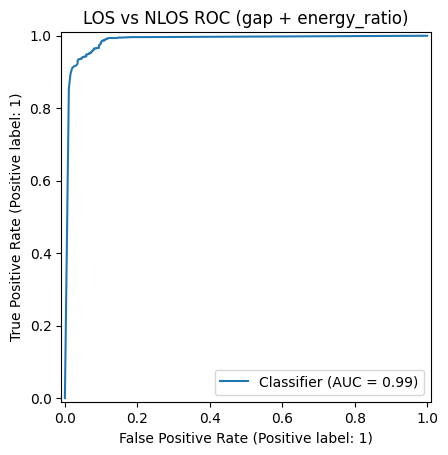

Feature importances (RandomForest):
energy_ratio    0.73
fp_fb_gap       0.27
dtype: float64


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

X = corr_df[feat_cols]
y = (corr_df['Label'] == 'NLOS').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=['LOS', 'NLOS']))
print('ROC-AUC:', roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('LOS vs NLOS ROC (gap + energy_ratio)')
plt.show()

importances = pd.Series(clf.feature_importances_, index=feat_cols).sort_values(ascending=False)
print('Feature importances (RandomForest):')
print(importances)


## 8. K-fold cross-validation
Check generalization across folds using stratified K-fold ROC-AUC and accuracy.

In [31]:
from sklearn.model_selection import StratifiedKFold, cross_validate

X = corr_df[feat_cols]
y = (corr_df['Label'] == 'NLOS').astype(int)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        class_weight='balanced'
    ),
    X, y,
    cv=cv,
    scoring={'auc': 'roc_auc', 'acc': 'accuracy'},
    n_jobs=1,  # use 1 on Windows to avoid _posixsubprocess issues
)

print('ROC-AUC per fold:', cv_results['test_auc'])
print('Accuracy per fold:', cv_results['test_acc'])
print('Mean ROC-AUC:', cv_results['test_auc'].mean(), '+/-', cv_results['test_auc'].std())
print('Mean Accuracy:', cv_results['test_acc'].mean(), '+/-', cv_results['test_acc'].std())


ROC-AUC per fold: [0.99044487 0.9955363  0.98887282 0.99034798 0.99043627]
Accuracy per fold: [0.95866455 0.96581876 0.9554849  0.95627981 0.96260939]
Mean ROC-AUC: 0.9911276468424222 +/- 0.0022835298535202756
Mean Accuracy: 0.9597714800297981 +/- 0.003909352264737115
